In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
import pyfolio as pf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

D:\anaconda3\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
class pair_trading():
    
    def __init__(self, ticker_x, ticker_y, start_date, end_date, lookback, std_dev):
        self.ticker_x = ticker_x
        self.ticker_y = ticker_y
        self.start_date = start_date
        self.end_date = end_date
        self.lookback = lookback
        self.std_dev = std_dev
        self.data = self.fetch_data()
        self.plot_price()
        self.hedge_ratio = self.calculate_spread()
        self.plot_spread()
        self.bollinger_bands()
        #self.check_stationary()
           
    def fetch_data(self):
        x = yf.download(tickers=self.ticker_x, start=self.start_date, end=self.end_date)['Adj Close']
        y = yf.download(tickers=self.ticker_y, start=self.start_date, end=self.end_date)['Adj Close']
        
        data = pd.concat([x,y], axis=1)
        data.columns = [self.ticker_x, self.ticker_y]
        print(data.head())
        return data
    
    def plot_price(self):
        self.data.plot(figsize = (15,7))
        plt.ylabel('Price')
        plt.show()
        
    def calculate_spread(self):
        model = sm.OLS(self.data[self.ticker_y].iloc[:90], self.data[self.ticker_x].iloc[:90])
        model = model.fit()
        hedge_ratio = model.params[0]
        self.data['spread'] = self.data[self.ticker_y] - hedge_ratio * self.data[self.ticker_x]
        print(self.data.head())
        print("Hedge Ratio", hedge_ratio)
        return hedge_ratio
        
    def plot_spread(self):
        self.data['spread'].plot(figsize=(12,5))
        plt.ylabel('Spread')
        plt.show()
    
    def check_stationary(self):
        adf = adfuller(self.data['spread'], maxlag=1)
        test_statistic = adf[0]
        critical_value = adf[4]['5%']
        print(test_statistic)
        print(critical_value)
        print("Critical Values", adf[4])
        print("Is Stationary", test_statistic < critical_value)
        return test_statistic < critical_value
    
    def bollinger_bands(self):
        if ~self.check_stationary():
            return
        self.data['MA'] = self.data['spread'].rolling(self.lookback).mean()
        self.data['MSTDEV'] = self.data['spread'].rolling(self.lookback).std()
        self.data['upper_band'] = self.data['MA'] + self.std_dev * self.data['MSTDEV']
        self.data['lower_band'] = self.data['MA'] - self.std_dev * self.data['MSTDEV']
        self.plot_BB()
        self.mean_reversion_strategy()
    
    def plot_BB(self):
        self.data[['spread', 'upper_band', 'lower_band']].plot(figsize=(15,7))
        plt.ylabel("Price")
        plt.show()
        
    def mean_reversion_strategy(self):
        self.data['long_entry'] = self.data['spread'] < self.data['lower_band']
        self.data['long_exit'] = self.data['spread'] >= self.data['MA']
        
        self.data['long_position'] = np.nan
        self.data.loc[self.data['long_entry'], 'long_position'] = 1
        self.data.loc[self.data['long_exit'], 'long_position'] = 0
        self.data['long_position'] = self.data['long_position'].fillna(method='ffill')
        
        self.data['short_entry'] = self.data['spread'] > self.data['upper_band']
        self.data['short_exit'] = self.data['spread'] <= self.data['MA']
        
        self.data['short_position'] = np.nan
        self.data.loc[self.data['short_entry'], 'short_position'] = -1
        self.data.loc[self.data['short_exit'], 'short_position'] = 0
        self.data['short_position'] = self.data['short_position'].fillna(method='ffill')
        
        self.data['positions'] = self.data['long_position'] + self.data['short_position']
        
        self.calculate_returns()
        
    def calculate_returns(self):
        self.data['percentage_change'] = (self.data['spread'] - self.data['spread'].shift(1)) / (self.hedge_ratio * self.data[self.ticker_x] + self.data[self.ticker_y])
        self.data['strategy_returns'] = self.data['positions'].shift(1) * self.data['percentage_change']
        self.data['cumulative_returns'] = (self.data['strategy_returns'] + 1).cumprod()
        
        print("Total Strategy Returns are: ", round((self.data['cumulative_returns'].iloc[-1] - 1) * 100, 2), "%")
        self.plot_returns()
        self.show_statistics()
        
    def plot_returns(self):
        self.data['cumulative_returns'].plot(figsize=(12,5))
        plt.xlabel("Date")
        plt.ylabel("Cumulative Returns")
        plt.show()
        
    def show_statistics(self):
        pf.create_simple_tear_sheet(self.data['strategy_returns'])

In [3]:
end_date = datetime.date.today()
start_date = end_date - pd.Timedelta(days = 10 * 365)

In [4]:
ticker_x = 'HDFCBANK.NS'
ticker_y = 'KOTAKBANK.NS'

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
            HDFCBANK.NS  KOTAKBANK.NS
Date                                 
2012-08-27   277.169830    285.726410
2012-08-28   274.838135    286.496796
2012-08-29   274.465088    288.509613
2012-08-30   277.892670    294.498505
2012-08-31   277.636169    285.328796


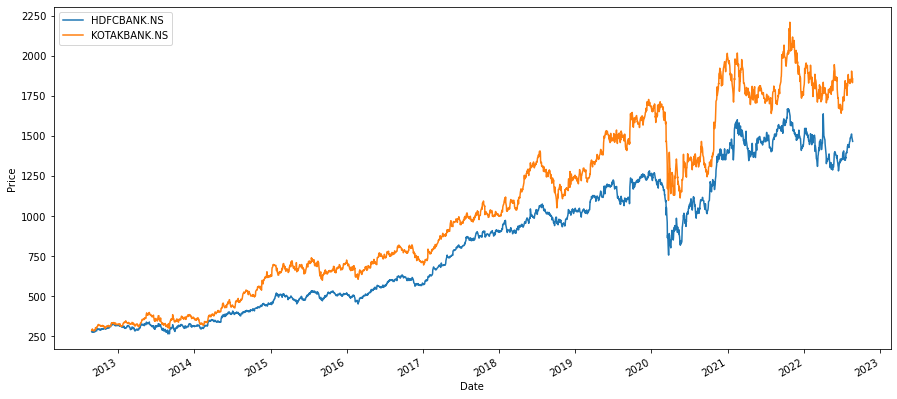

            HDFCBANK.NS  KOTAKBANK.NS    spread
Date                                           
2012-08-27   277.169830    285.726410 -2.352053
2012-08-28   274.838135    286.496796  0.841797
2012-08-29   274.465088    288.509613  3.242343
2012-08-30   277.892670    294.498505  5.668753
2012-08-31   277.636169    285.328796 -3.234360
Hedge Ratio 1.039357216564356


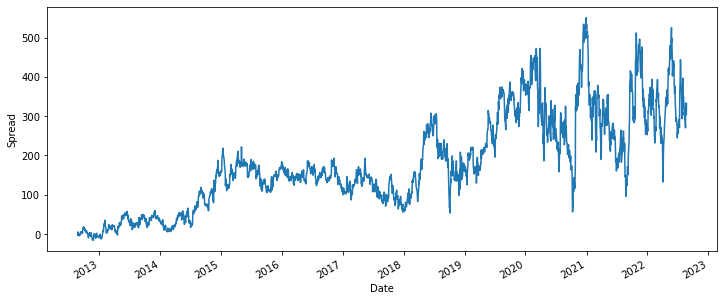

-3.4714165849348935
-2.8627151430515654
Critical Values {'1%': -3.4330099487687264, '5%': -2.8627151430515654, '10%': -2.5673955755408095}
Is Stationary True


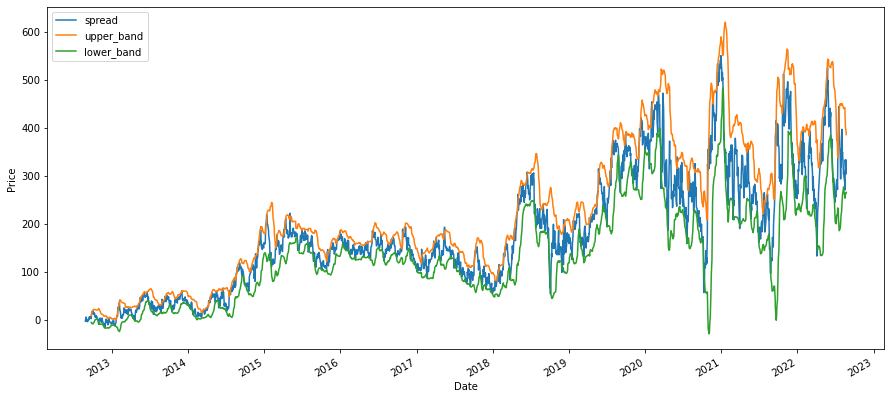

Total Strategy Returns are:  133.83 %


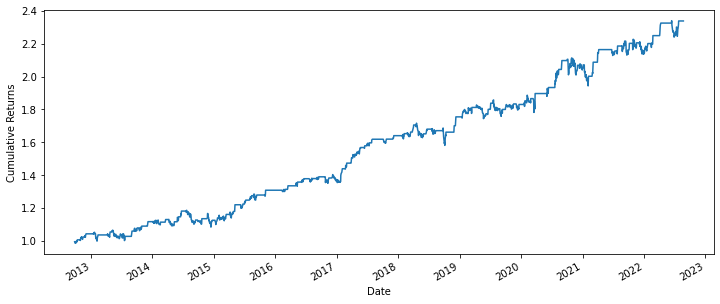

Start date,2012-08-27
End date,2022-08-23
Total months,117
,Backtest
Annual return,9.1%
Cumulative returns,133.8%
Annual volatility,8.1%
Sharpe ratio,1.12
Calmar ratio,1.05
Stability,0.99
Max drawdown,-8.6%


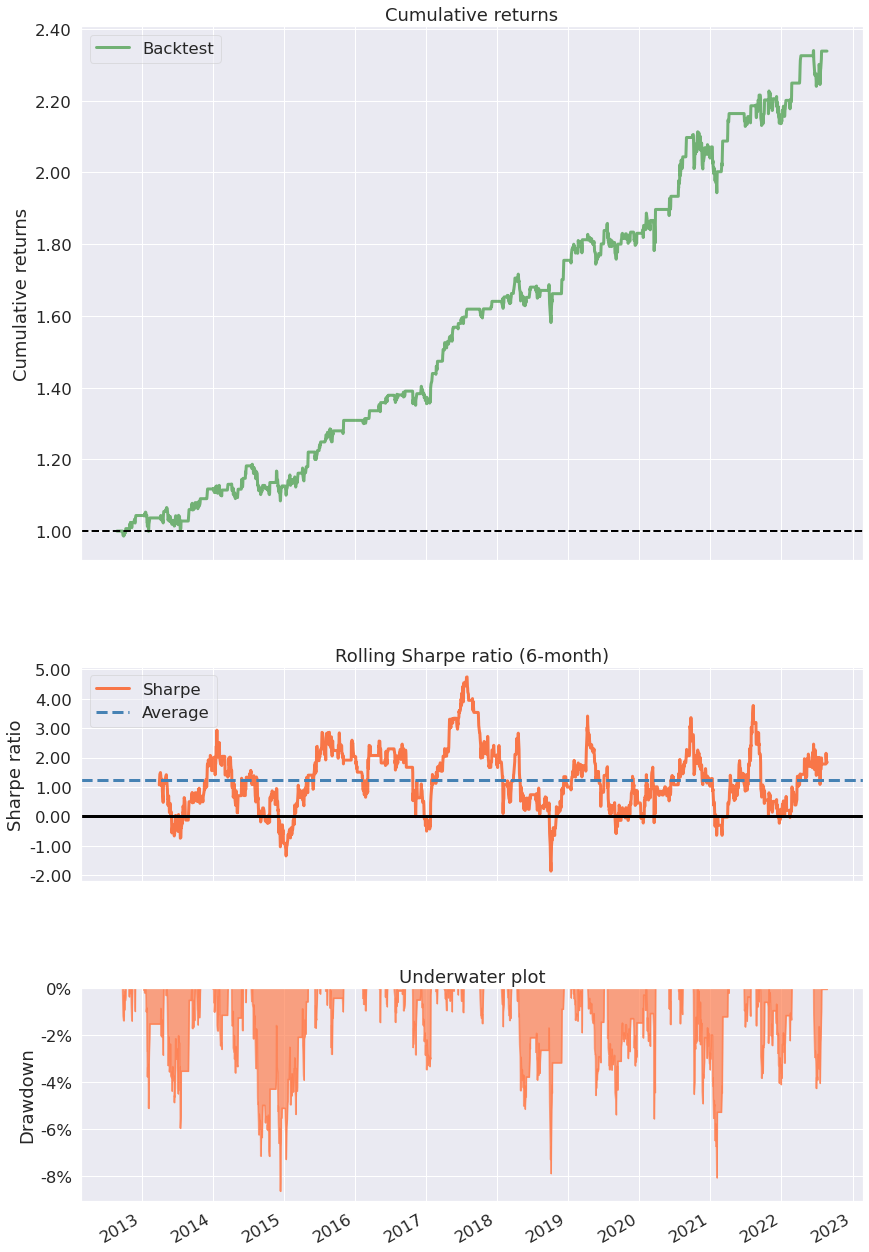

In [5]:
pt = pair_trading(ticker_x, ticker_y, start_date, end_date, 20, 2)

In [6]:
#end_date1 = datetime.date.today()
#start_date1 = end_date1 - pd.Timedelta(days = 5 * 365)

In [7]:
#pt2 = pair_trading('HINDALCO.NS','JSWSTEEL.NS', start_date1, end_date1)